🔍 Missing-value count BEFORE imputation:
job_title           0
skills              0
location            0
years_experience    0
education_level     0
expected_salary     0
dtype: int64

 Missing-value count AFTER imputation:
job_title           0
skills              0
location            0
years_experience    0
education_level     0
expected_salary     0
dtype: int64


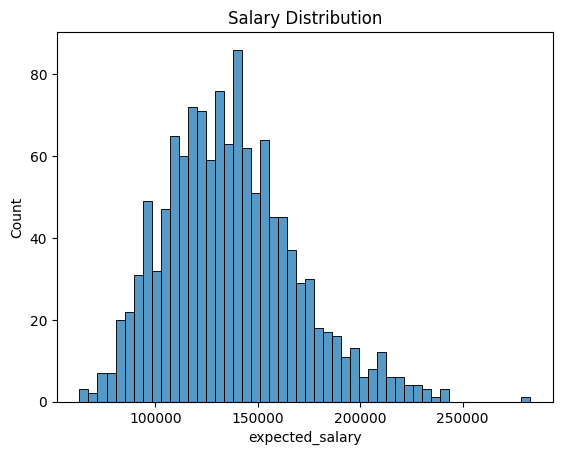


 MAE           : Rs. 10,316
 R²            : 0.80
Accuracy: 80.19%
 OOB Score     : 0.81


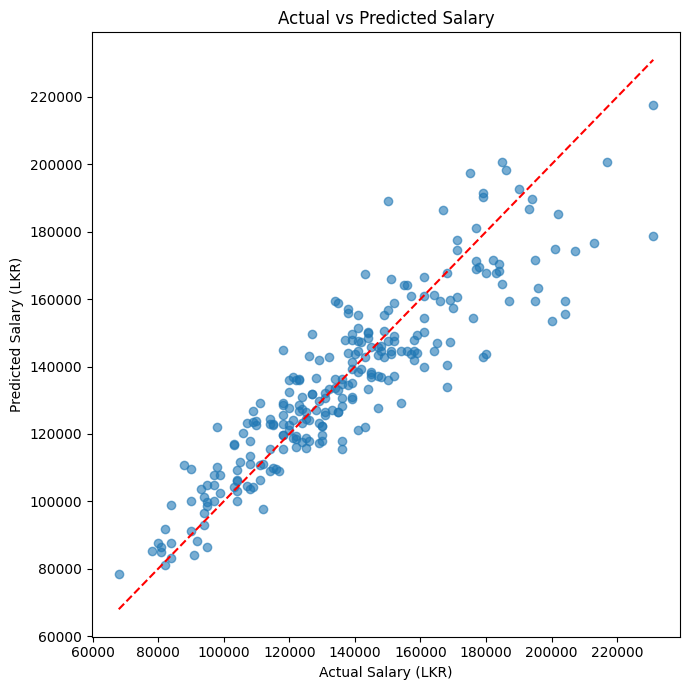

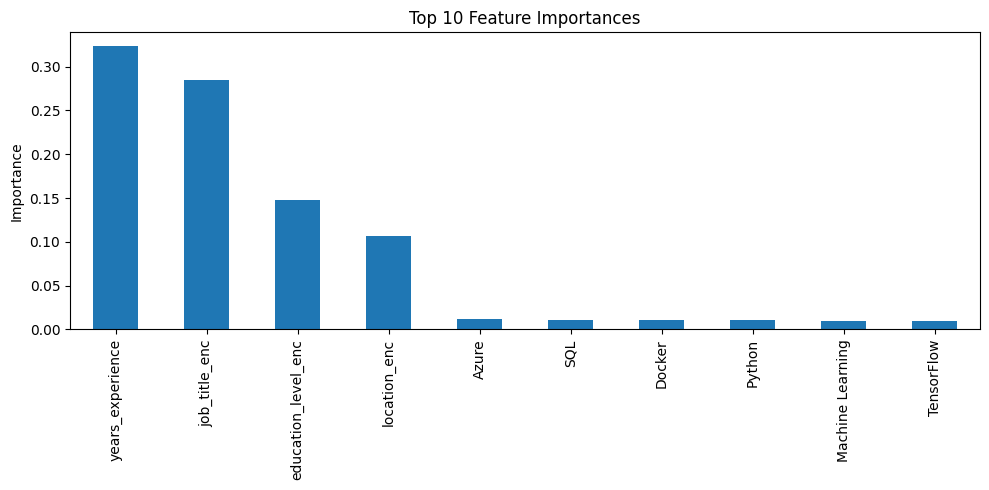


 Top 10 features:
years_experience       0.323073
job_title_enc          0.285163
education_level_enc    0.148173
location_enc           0.106984
Azure                  0.011857
SQL                    0.010910
Docker                 0.010343
Python                 0.010175
Machine Learning       0.009771
TensorFlow             0.009270
dtype: float64

 Model, encoders, and scaler saved to disk.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import joblib
from pathlib import Path


# 1. Load data

DATA_PATH = Path("../data/sl_tech_jobs_mock.csv")   # adjust if needed
df = pd.read_csv(DATA_PATH)


# 2. Missing-value inspection & imputation

print("🔍 Missing-value count BEFORE imputation:")
print(df.isna().sum())

# — Simple strategy —
# • Numeric: median
# • Categorical: mode
# • 'skills': empty string
num_cols  = ["years_experience", "expected_salary"]
cat_cols  = ["job_title", "location", "education_level"]
skills_col = "skills"

for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

df[skills_col] = df[skills_col].fillna("")

print("\n Missing-value count AFTER imputation:")
print(df.isna().sum())


# 3. Exploratory plots (optional)

sns.histplot(df["expected_salary"], bins=50)
plt.title("Salary Distribution")
plt.show()


# 4. Feature engineering

# Split skills into list
df["skills_list"] = df["skills"].apply(lambda x: [s.strip() for s in x.split(",") if s.strip()])

# ── Multi-label one-hot for skills ──
mlb = MultiLabelBinarizer()
skills_encoded = mlb.fit_transform(df["skills_list"])
skills_df = pd.DataFrame(skills_encoded, columns=mlb.classes_)

# ── Label encoders for single-label categorical features ──
le_job = LabelEncoder()
le_loc = LabelEncoder()
le_edu = LabelEncoder()

df["job_title_enc"]        = le_job.fit_transform(df["job_title"])
df["location_enc"]         = le_loc.fit_transform(df["location"])
df["education_level_enc"]  = le_edu.fit_transform(df["education_level"])

# ── Combine all features ──
X = pd.concat(
    [
        skills_df.reset_index(drop=True),
        df[["job_title_enc", "location_enc", "education_level_enc", "years_experience"]],
    ],
    axis=1,
)
y = df["expected_salary"]


# 5. Train / test split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)


# 6. Z-score scaling of numeric feature(s)
#    (Here only years_experience, but you can add more)

numeric_cols = ["years_experience"]

scaler = StandardScaler()
# Fit on training numeric columns, transform both train & test
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols]  = scaler.transform(X_test[numeric_cols])


# 7. Model training

model = RandomForestRegressor(
    n_estimators=100, random_state=42, n_jobs=-1, oob_score=True
)
model.fit(X_train, y_train)


# 8. Evaluation

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)

print(f"\n MAE           : Rs. {mae:,.0f}")
print(f" R²            : {r2:.2f}")
print("Accuracy: {:.2f}%".format(r2 * 100))
print(f" OOB Score     : {model.oob_score_:.2f}")

# — Actual vs Predicted plot —
plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Actual Salary (LKR)")
plt.ylabel("Predicted Salary (LKR)")
plt.title("Actual vs Predicted Salary")
plt.tight_layout()
plt.savefig("actual_vs_predicted_salary.png")
plt.show()

# — Feature importances —
feature_importances = pd.Series(
    model.feature_importances_, index=X.columns
).sort_values(ascending=False)

top10 = feature_importances.head(10)
plt.figure(figsize=(10, 5))
top10.plot(kind="bar")
plt.title("Top 10 Feature Importances")
plt.ylabel("Importance")
plt.tight_layout()
plt.savefig("top_feature_importances.png")
plt.show()

print("\n Top 10 features:")
print(top10)


# 9. Persist model + artefacts

OUT_DIR = Path(".")
joblib.dump(model,   OUT_DIR / "../models/salary_predictor.pkl")
joblib.dump(le_job,  OUT_DIR / "../models/le_job.pkl")
joblib.dump(le_loc,  OUT_DIR / "../models/le_loc.pkl")
joblib.dump(le_edu,  OUT_DIR / "../models/le_edu.pkl")
joblib.dump(mlb,     OUT_DIR / "../models/mlb_skills.pkl")
joblib.dump(scaler,  OUT_DIR / "../models/scaler_years_exp.pkl")

print("\n Model, encoders, and scaler saved to disk.")
